### Data Scientist Assessment for Evil Genius

#### problem 

In [1]:
import pandas as pd
import numpy as np
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Your code here
# ...


df = pd.read_csv("D:/MSIA/Intern/Assessment/data/starcraft_player_data.csv")
df.head(5)
df.shape



(3395, 20)

In [2]:
df.describe()
df.columns

Index(['GameID', 'LeagueIndex', 'Age', 'HoursPerWeek', 'TotalHours', 'APM',
       'SelectByHotkeys', 'AssignToHotkeys', 'UniqueHotkeys', 'MinimapAttacks',
       'MinimapRightClicks', 'NumberOfPACs', 'GapBetweenPACs', 'ActionLatency',
       'ActionsInPAC', 'TotalMapExplored', 'WorkersMade', 'UniqueUnitsMade',
       'ComplexUnitsMade', 'ComplexAbilitiesUsed'],
      dtype='object')

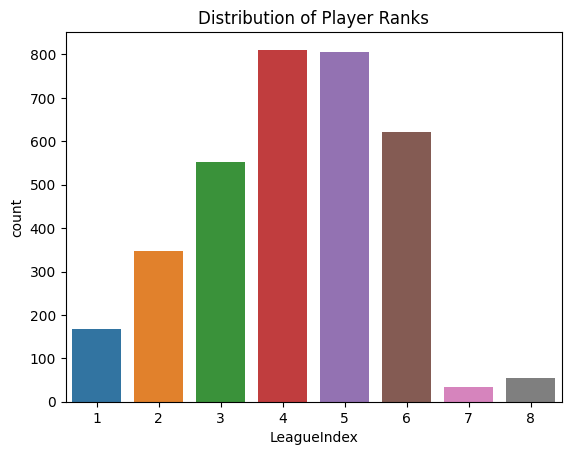

In [3]:

import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of LeagueIndex (Rank)
sns.countplot(x='LeagueIndex', data=df)
plt.title('Distribution of Player Ranks')
plt.show()


In [5]:
df.Age

0       27
1       23
2       30
3       19
4       32
        ..
3390     ?
3391     ?
3392     ?
3393     ?
3394     ?
Name: Age, Length: 3395, dtype: object

In [4]:
# Convert 'Age' column to integer type
# df['Age'] = df['Age'].astype(int)
df.Age.value_counts()


Age
20    357
21    344
18    325
22    314
19    313
23    259
16    256
17    248
24    225
25    168
26    136
27    111
28     73
?      55
29     52
30     32
31     29
32     21
35     17
33     15
34     15
36      8
38      5
37      5
40      4
41      3
39      3
43      1
44      1
Name: count, dtype: int64

In [5]:
df.LeagueIndex.value_counts()

LeagueIndex
4    811
5    806
6    621
3    553
2    347
1    167
8     55
7     35
Name: count, dtype: int64

#### 
Deal with 55 ? values in Age column.
Assign the average age from index 7 --> 8 replace ?


In [6]:
# Replace '?' values with NaN
df['Age'] = df['Age'].replace('?', np.nan)

# drop NaN rows
df = df.dropna()

# Convert 'Age' column to integer type, ignoring NaN values
df['Age'] = df['Age'].astype(int)


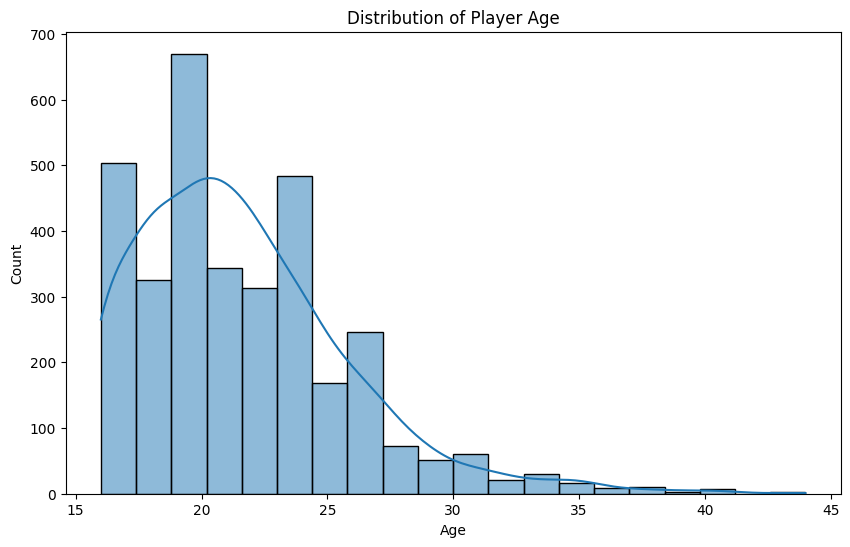

In [7]:

# Distribution of Age
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Age', bins=20, kde=True)
plt.title('Distribution of Player Age')
plt.xlabel('Age')
plt.ylabel('Count')
# plt.gca().invert_xaxis()  # Invert the x-axis to display age in ascending order
plt.show()


#### 
the Age is skewed and need normalize before neural network. Let's see if other features also need normalize before model training.

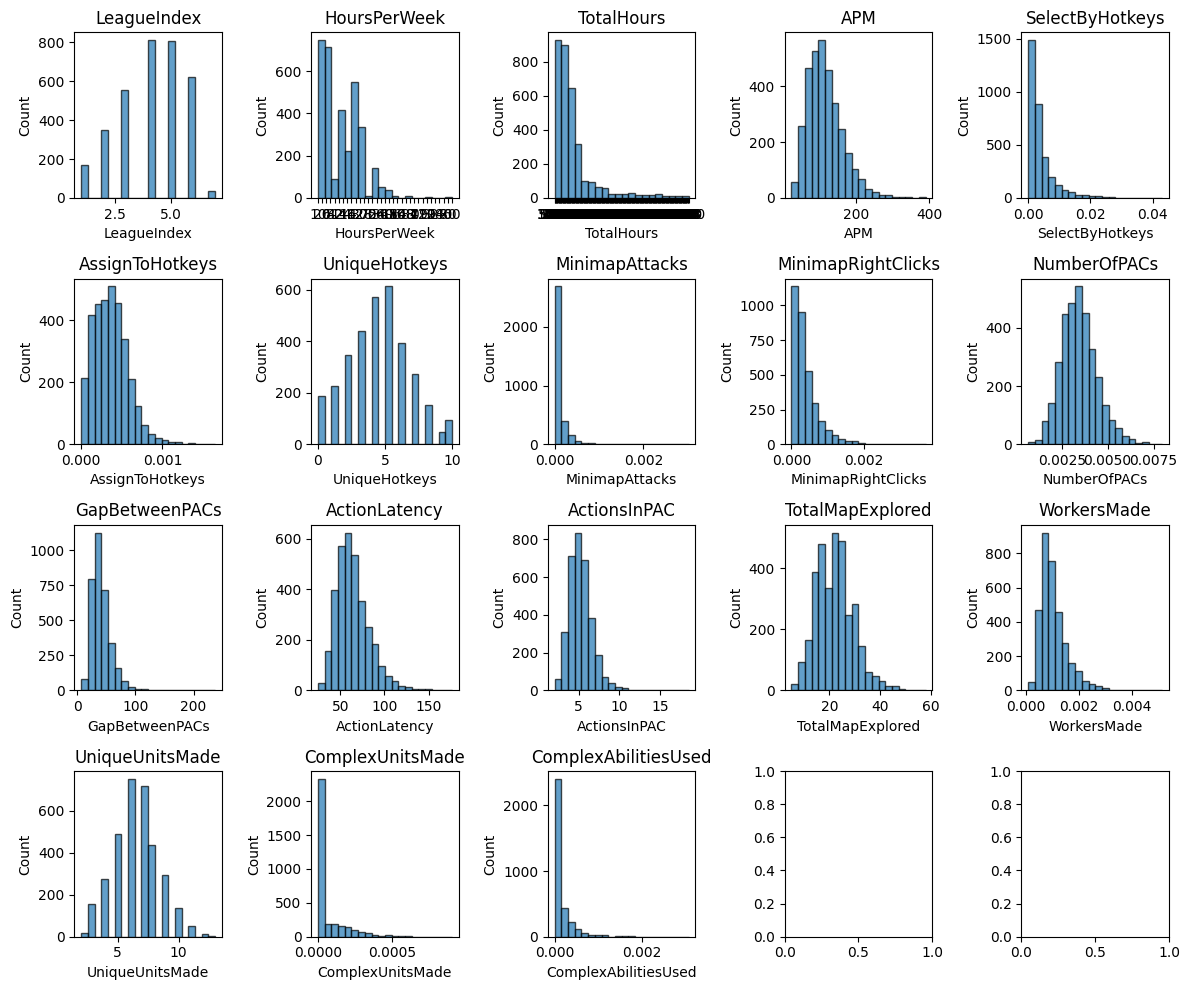

In [8]:

# Define the variables for the histograms
variables = ['LeagueIndex', 'HoursPerWeek', 'TotalHours', 'APM', 'SelectByHotkeys',
             'AssignToHotkeys', 'UniqueHotkeys', 'MinimapAttacks', 'MinimapRightClicks',
             'NumberOfPACs', 'GapBetweenPACs', 'ActionLatency', 'ActionsInPAC',
             'TotalMapExplored', 'WorkersMade', 'UniqueUnitsMade', 'ComplexUnitsMade',
             'ComplexAbilitiesUsed']

# Create a 4x5 grid of histograms
fig, axes = plt.subplots(4, 5, figsize=(12, 10))
axes = axes.flatten()

# Iterate over variables and create histograms
for i, variable in enumerate(variables):
    axes[i].hist(df[variable], bins=20, edgecolor='black', alpha=0.7)
    axes[i].set_title(variable)
    axes[i].set_xlabel(variable)
    axes[i].set_ylabel('Count')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


#### 
From the histogram result, the following features do not need log tranformation: LeagueIndex, UniqueHotkeys, NumberOfPACs, ActionLatency, ActionsInPAC, TotalMapExplored, UniqueUnitsMade.

In [9]:

for variable in df.columns:
    non_numeric_values = df[variable].loc[~pd.to_numeric(df[variable], errors='coerce').notnull()]
    if len(non_numeric_values) > 0:
        print(f"Variable '{variable}' contains non-integer or non-float values.")


Variable 'HoursPerWeek' contains non-integer or non-float values.
Variable 'TotalHours' contains non-integer or non-float values.


In [10]:
df.HoursPerWeek.value_counts()
# Replace '?' values with NaN
df['HoursPerWeek'] = df['HoursPerWeek'].replace('?', np.nan)

# drop NaN rows
df = df.dropna()

# Convert 'HoursPerWeek' column to integer type, ignoring NaN values
df['HoursPerWeek'] = df['HoursPerWeek'].astype(int)


In [11]:
df.TotalHours.value_counts()
# Replace '?' values with NaN
df['TotalHours'] = df['TotalHours'].replace('?', np.nan)

# drop NaN rows
df = df.dropna()

# Convert 'TotalHours' column to integer type, ignoring NaN values
df['TotalHours'] = df['TotalHours'].astype(int)

In [24]:
df.shape

(3338, 20)

In [12]:
df.LeagueIndex.value_counts()

LeagueIndex
4    811
5    804
6    621
3    553
2    347
1    167
7     35
Name: count, dtype: int64

#### 
Now the data types are either integer or float.

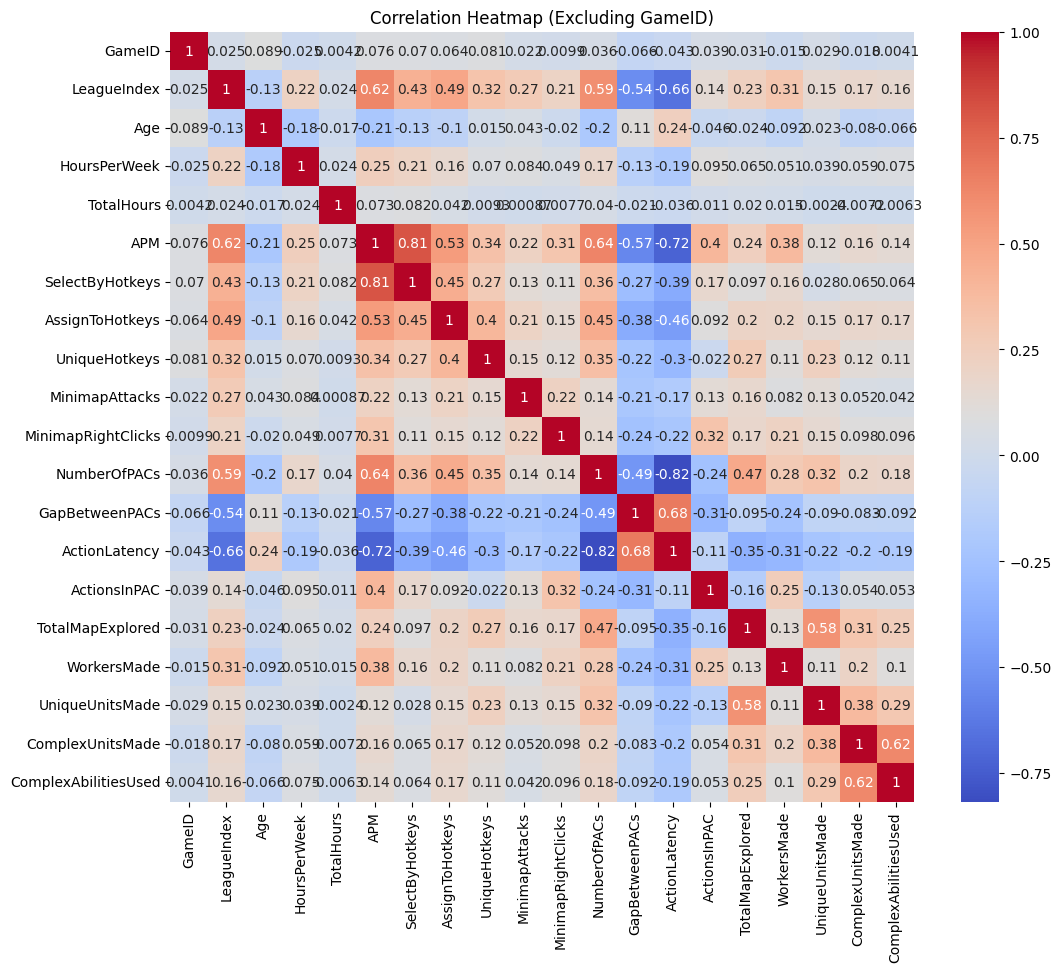

In [14]:

# Compute the correlation matrix
corr_matrix = df.corr()

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Excluding GameID)')
plt.show()


####
Model

####
Logistic regression

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler


# Select features and target variable
features = ['Age', 'HoursPerWeek', 'TotalHours', 'APM', 'SelectByHotkeys', 'AssignToHotkeys',
            'UniqueHotkeys', 'MinimapAttacks', 'MinimapRightClicks', 'NumberOfPACs',
            'GapBetweenPACs', 'ActionLatency', 'ActionsInPAC', 'TotalMapExplored',
            'WorkersMade', 'UniqueUnitsMade', 'ComplexUnitsMade', 'ComplexAbilitiesUsed']
target = 'LeagueIndex'

# Prepare the data
X = df[features]
y = df[target]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify the skewed variables
skewed_vars = ['HoursPerWeek', 'TotalHours', 'APM', 'SelectByHotkeys', 'AssignToHotkeys',
               'MinimapAttacks', 'MinimapRightClicks', 'GapBetweenPACs', 'WorkersMade',
               'ComplexUnitsMade', 'ComplexAbilitiesUsed']

# Normalize skewed variables using log transformation
X_train[skewed_vars] = np.log1p(X_train[skewed_vars])
X_test[skewed_vars] = np.log1p(X_test[skewed_vars])

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build and train the logistic regression model
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = logreg.predict(X_test_scaled)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.43      0.25      0.32        24
           2       0.35      0.29      0.32        69
           3       0.37      0.29      0.33       102
           4       0.37      0.48      0.42       151
           5       0.38      0.48      0.43       157
           6       0.63      0.49      0.55       161
           7       0.00      0.00      0.00         4

    accuracy                           0.42       668
   macro avg       0.36      0.33      0.34       668
weighted avg       0.43      0.42      0.42       668



c:\Users\bobby\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


####
Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report

# Split the data into features (X) and target variable (y)
X = df.drop('LeagueIndex', axis=1)
y = df['LeagueIndex']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:


# Define the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=kfold, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)




Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END ma

In [26]:
# Predict on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.47      0.33      0.39        24
           2       0.38      0.26      0.31        69
           3       0.35      0.34      0.35       102
           4       0.40      0.49      0.44       151
           5       0.38      0.50      0.43       157
           6       0.69      0.48      0.57       161
           7       0.00      0.00      0.00         4

    accuracy                           0.44       668
   macro avg       0.38      0.34      0.36       668
weighted avg       0.46      0.44      0.44       668



c:\Users\bobby\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bobby\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bobby\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [31]:
# %pip install xgboost

####
Xgboost

In [25]:
df['LeagueIndex'] = df['LeagueIndex'] - 1

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report

# Split the data into features (X) and target variable (y)
X = df.drop('LeagueIndex', axis=1)
y = df['LeagueIndex']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report

# Define the XGBoost classifier
xgb = XGBClassifier(random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform grid search with cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=kfold, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)




Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END 

In [28]:
# Predict on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.32      0.29      0.30        24
           1       0.35      0.23      0.28        69
           2       0.31      0.29      0.30       102
           3       0.34      0.34      0.34       151
           4       0.37      0.48      0.42       157
           5       0.64      0.57      0.61       161
           6       0.00      0.00      0.00         4

    accuracy                           0.41       668
   macro avg       0.33      0.32      0.32       668
weighted avg       0.41      0.41      0.41       668



##
Neural Network

In [29]:
df['LeagueIndex'] = df['LeagueIndex'] + 1

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report


# Select features and target variable
features = ['Age', 'HoursPerWeek', 'TotalHours', 'APM', 'SelectByHotkeys', 'AssignToHotkeys',
            'UniqueHotkeys', 'MinimapAttacks', 'MinimapRightClicks', 'NumberOfPACs',
            'GapBetweenPACs', 'ActionLatency', 'ActionsInPAC', 'TotalMapExplored',
            'WorkersMade', 'UniqueUnitsMade', 'ComplexUnitsMade', 'ComplexAbilitiesUsed']
target = 'LeagueIndex'

# Prepare the data
X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize skewed variables using log transformation
skewed_vars = ['HoursPerWeek', 'TotalHours', 'APM', 'SelectByHotkeys', 'AssignToHotkeys',
               'MinimapAttacks', 'MinimapRightClicks', 'GapBetweenPACs', 'WorkersMade',
               'ComplexUnitsMade', 'ComplexAbilitiesUsed']
X_train[skewed_vars] = np.log1p(X_train[skewed_vars])
X_test[skewed_vars] = np.log1p(X_test[skewed_vars])

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the neural network classifier
mlp = MLPClassifier(random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'hidden_layer_sizes': [(100,), (200,), (300,)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
}


In [31]:

# Perform grid search with cross-validation
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


c:\Users\bobby\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bobby\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bobby\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bobby\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

Best Parameters:  {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (200,)}
Best Score:  0.41235955056179774


c:\Users\bobby\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [32]:

# Predict on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.26      0.21      0.23        24
           2       0.39      0.28      0.32        69
           3       0.32      0.32      0.32       102
           4       0.34      0.36      0.35       151
           5       0.35      0.42      0.38       157
           6       0.61      0.57      0.59       161
           7       0.00      0.00      0.00         4

    accuracy                           0.40       668
   macro avg       0.32      0.31      0.31       668
weighted avg       0.40      0.40      0.40       668



c:\Users\bobby\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bobby\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bobby\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [1]:
df.LeagueIndex.value_counts()

NameError: name 'df' is not defined